In [16]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [329]:
from argparse import ArgumentParser
from pathlib import Path
import typing as tp

import torch

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from ml_collections import ConfigDict

%autoreload 2
from train_with_stylegan.trainer import DIffGANTrainer
from train_with_stylegan.utils import configure_unet_model_from_pretrained
from train_with_stylegan.train import load_params, configure_checkpoint_path

In [254]:
device = torch.device(f"{args.device}") if torch.cuda.is_available else torch.device("cpu")
teacher = configure_unet_model_from_pretrained(args.teacher)
student = configure_unet_model_from_pretrained(args.teacher)

teacher.to(device)
student.to(device)

teacher.eval()
student.train()

log_dir, last_ckpt = configure_checkpoint_path(args)

### Config from diffusers

In [116]:
from diffusers import DDPMPipeline

In [117]:
ddpm_pipeline = DDPMPipeline.from_pretrained("google/ddpm-cifar10-32")

In [118]:
ddpm_pipeline.scheduler

DDPMScheduler {
  "_class_name": "DDPMScheduler",
  "_diffusers_version": "0.18.2",
  "beta_end": 0.02,
  "beta_schedule": "linear",
  "beta_start": 0.0001,
  "clip_sample": true,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "sample_max_value": 1.0,
  "steps_offset": 0,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null,
  "variance_type": "fixed_large"
}

### Sample Images

In [301]:
args = dict(
    name="student",
    teacher="google/ddpm-cifar10-32",
    params=Path("./train_with_stylegan/params/boot.yaml"),
    device="cpu",
    project="boot",
    dir=Path("boot-ckpt")
)
args = ConfigDict(args)
params = load_params(args)

In [336]:
# Run if you want discrete sampler
params.training.continuous = False
params.training.beta_min = 0.0001
params.training.beta_max = 0.02

In [337]:
trainer = DIffGANTrainer(
    teacher=teacher,
    student=student,
    params=params,
    device=device,
    log_dir=log_dir,
)

print(params.training.continuous)
print(params.training.beta_max)
print(params.training.beta_min)

False
0.02
0.0001


In [331]:
images = trainer.sample_with_teacher(2)

Sampling images with teacher...:  10%|██▋                        | 100/1000 [00:32<04:47,  3.13it/s]

tensor([[[0.0003]]]) tensor([[[0.9955]]]) tensor([[[0.0178]]])


Sampling images with teacher...:  20%|█████▍                     | 200/1000 [01:05<04:19,  3.08it/s]

tensor([[[0.0006]]]) tensor([[[0.9960]]]) tensor([[[0.0159]]])


Sampling images with teacher...:  30%|████████                   | 300/1000 [01:37<03:41,  3.16it/s]

tensor([[[0.0012]]]) tensor([[[0.9964]]]) tensor([[[0.0139]]])


Sampling images with teacher...:  40%|██████████▊                | 400/1000 [02:15<05:38,  1.77it/s]

tensor([[[0.0020]]]) tensor([[[0.9967]]]) tensor([[[0.0120]]])


Sampling images with teacher...:  50%|█████████████▌             | 500/1000 [02:55<03:26,  2.42it/s]

tensor([[[0.0031]]]) tensor([[[0.9966]]]) tensor([[[0.0100]]])


Sampling images with teacher...:  60%|████████████████▏          | 600/1000 [03:34<02:27,  2.71it/s]

tensor([[[0.0044]]]) tensor([[[0.9960]]]) tensor([[[0.0080]]])


Sampling images with teacher...:  70%|██████████████████▉        | 700/1000 [04:12<02:16,  2.20it/s]

tensor([[[0.0063]]]) tensor([[[0.9945]]]) tensor([[[0.0060]]])


Sampling images with teacher...:  80%|█████████████████████▌     | 800/1000 [04:54<01:20,  2.49it/s]

tensor([[[0.0097]]]) tensor([[[0.9911]]]) tensor([[[0.0041]]])


Sampling images with teacher...:  90%|████████████████████████▎  | 900/1000 [05:35<00:43,  2.29it/s]

tensor([[[0.0190]]]) tensor([[[0.9815]]]) tensor([[[0.0021]]])


tensor([[[1.0588]]]) tensor([[[0.]]]) tensor([[[1.0729e-06]]])


In [ ]:
discrete_images = trainer.sample_with_teacher(2)

Sampling images with teacher...:  10%|██▋                        | 100/1000 [00:41<05:24,  2.77it/s]

tensor([[[0.0003]]]) tensor([[[0.9909]]]) tensor([[[0.0180]]])


Sampling images with teacher...:  20%|█████▍                     | 200/1000 [01:19<04:56,  2.70it/s]

tensor([[[0.0006]]]) tensor([[[0.9919]]]) tensor([[[0.0160]]])


Sampling images with teacher...:  30%|████████                   | 300/1000 [02:01<04:17,  2.72it/s]

tensor([[[0.0012]]]) tensor([[[0.9929]]]) tensor([[[0.0140]]])


Sampling images with teacher...:  40%|██████████▊                | 400/1000 [02:40<03:33,  2.81it/s]

tensor([[[0.0020]]]) tensor([[[0.9936]]]) tensor([[[0.0121]]])


Sampling images with teacher...:  40%|██████████▊                | 402/1000 [02:41<03:30,  2.84it/s]

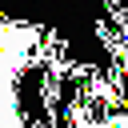

In [332]:
# images = trainer.sample_with_teacher(2)
np_images = images.permute(0, 2, 3, 1).numpy()
Image.fromarray(np.uint8(np_images[1] * 255)).resize((128,128), Image.BICUBIC)

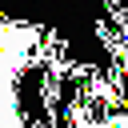

In [335]:
idx = 1
Image.fromarray(np.uint8(images.permute(0, 2, 3, 1).numpy()[idx] * 255)).resize((128,128), Image.BICUBIC)

In [328]:
U = np.linspace(0, 1, 1000)
1e-5 + (1 - 1e-5) * U

array([1.00000000e-05, 1.01099099e-03, 2.01198198e-03, 3.01297297e-03,
       4.01396396e-03, 5.01495495e-03, 6.01594595e-03, 7.01693694e-03,
       8.01792793e-03, 9.01891892e-03, 1.00199099e-02, 1.10209009e-02,
       1.20218919e-02, 1.30228829e-02, 1.40238739e-02, 1.50248649e-02,
       1.60258559e-02, 1.70268468e-02, 1.80278378e-02, 1.90288288e-02,
       2.00298198e-02, 2.10308108e-02, 2.20318018e-02, 2.30327928e-02,
       2.40337838e-02, 2.50347748e-02, 2.60357658e-02, 2.70367568e-02,
       2.80377477e-02, 2.90387387e-02, 3.00397297e-02, 3.10407207e-02,
       3.20417117e-02, 3.30427027e-02, 3.40436937e-02, 3.50446847e-02,
       3.60456757e-02, 3.70466667e-02, 3.80476577e-02, 3.90486486e-02,
       4.00496396e-02, 4.10506306e-02, 4.20516216e-02, 4.30526126e-02,
       4.40536036e-02, 4.50545946e-02, 4.60555856e-02, 4.70565766e-02,
       4.80575676e-02, 4.90585586e-02, 5.00595495e-02, 5.10605405e-02,
       5.20615315e-02, 5.30625225e-02, 5.40635135e-02, 5.50645045e-02,
      

### Experiments with functions

In [121]:
T = 1000
betas = np.linspace(0.0001, 0.02, T, dtype=np.float64)
self_alphas_cumprod = np.cumprod(1 - betas)

t = 34

alpha_prod_t = self_alphas_cumprod[t]
beta_prod_t = 1 - alpha_prod_t

sigma_fn(torch.tensor(t / T)), beta_prod_t**0.5

(tensor(0.1216), 0.12344683312338371)

In [122]:
alpha_prod_t ** 0.5, alpha_fn(torch.tensor(t / T))

(0.9923511875298016, tensor(0.9926))

In [117]:
T = 1000
betas = np.linspace(0.0001, 0.02, T, dtype=np.float64)
self_alphas_cumprod = np.cumprod(1 - betas)


x_0_coeff = []
x_t_coeff = []
x_0_coeff_c = []
x_t_coeff_c = []
prev_t = -1
for t in range(T):
    alpha_prod_t = self_alphas_cumprod[t]
    alpha_prod_t_prev = self_alphas_cumprod[prev_t] if prev_t >= 0 else 1
    beta_prod_t = 1 - alpha_prod_t
    beta_prod_t_prev = 1 - alpha_prod_t_prev
    current_alpha_t = alpha_prod_t / alpha_prod_t_prev
    current_beta_t = 1 - current_alpha_t
    
    pred_original_sample_coeff = (alpha_prod_t_prev ** (0.5) * current_beta_t) / beta_prod_t
    current_sample_coeff = current_alpha_t ** (0.5) * beta_prod_t_prev / beta_prod_t
    x_0_coeff.append(pred_original_sample_coeff)
    x_t_coeff.append(current_sample_coeff)
    prev_t = t
    
    t = torch.ones(1) * t
    t_tilda = torch.maximum(t / 1000, torch.tensor(1e-6))
    t_prev_tilda = torch.maximum((t - 1) / 1000, torch.tensor(1e-6))

    alpha_t = alpha_fn(t_tilda).numpy()[0]
    alpha_prev = alpha_fn(t_prev_tilda).numpy()[0]
    if alpha_t == alpha_prev:
        alpha_prev = 1

    sigma_t = sigma_fn(t_tilda).numpy()[0]
    sigma_prev = sigma_fn(t_prev_tilda).numpy()[0]
    if sigma_t == sigma_prev:
        sigma_prev = 0
    
    pred_original_sample_coeff = (alpha_prev / sigma_t ** 2) * (1 - (alpha_t / alpha_prev) ** 2)
    current_sample_coeff = np.sqrt(alpha_t / alpha_prev) * ((sigma_prev / sigma_t) ** 2)
    x_0_coeff_c.append(pred_original_sample_coeff)
    x_t_coeff_c.append(current_sample_coeff)
    
# x_0_coeff_c =  np.array(x_0_coeff_c).flatten()
# x_0_coeff_c[0] = 1
# x_t_coeff_c =  np.array(x_t_coeff_c).flatten()
# x_t_coeff_c[0] = 0

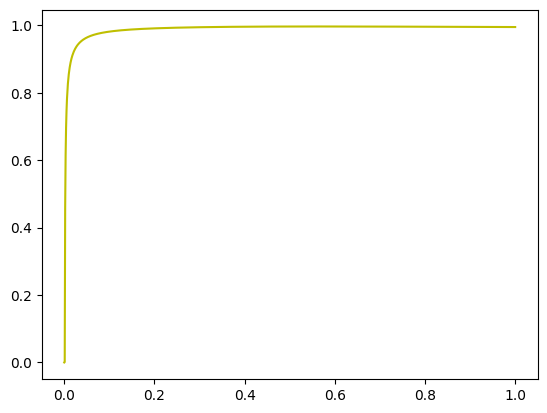

In [119]:
t = np.linspace(0, 1, T)
# plt.plot(t, np.array(x_0_coeff), c="r")
# plt.plot(t, x_t_coeff, c="b")
# plt.plot(t, np.array(x_0_coeff_c), c="g")
plt.plot(t, x_t_coeff_c, c="y")
plt.show()

In [40]:
alpha_fn = trainer._diffusion_scheduler._alpha_fn
sigma_fn = trainer._diffusion_scheduler._sigma_fn

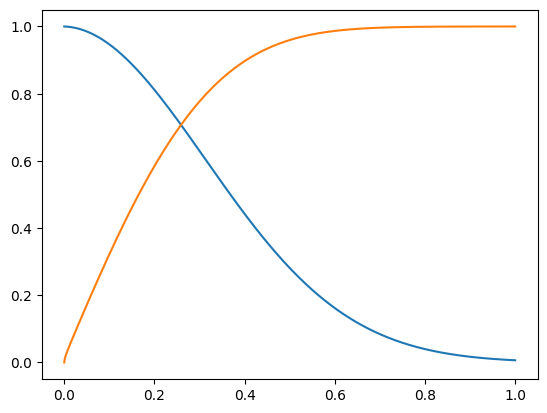

In [41]:
t = np.linspace(0, 1, 1000)
plt.plot(t, alpha_fn(torch.from_numpy(t)).numpy())
plt.plot(t, sigma_fn(torch.from_numpy(t)).numpy())
plt.show()

In [15]:
images = trainer.sample_with_teacher(2)

In [9]:
img = images.permute(0, 2, 3, 1).detach().numpy()
img.shape

(1, 32, 32, 3)

In [10]:
img[0].shape

(32, 32, 3)

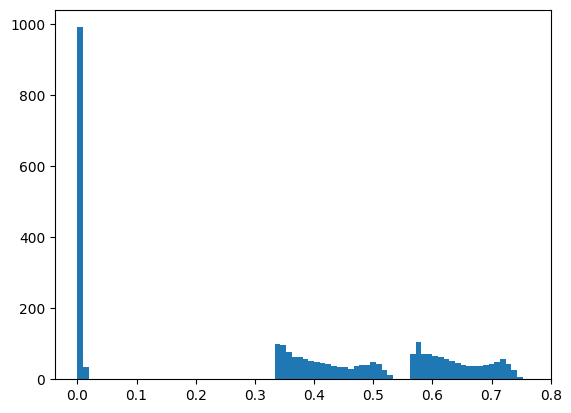

In [11]:
plt.hist(img.reshape(-1), bins=80)
plt.show()

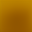

In [12]:
img = images.permute(0, 2, 3, 1).detach().numpy()
Image.fromarray(np.uint8(img[0] * 255))

In [13]:
np.uint8(img[0] * 255)

array([[[190, 138,   2],
        [189, 134,   3],
        [188, 134,   2],
        ...,
        [189, 133,   1],
        [190, 134,   1],
        [194, 135,   3]],

       [[188, 135,   0],
        [186, 132,   3],
        [186, 132,   1],
        ...,
        [187, 131,   0],
        [188, 132,   0],
        [190, 134,   1]],

       [[187, 135,   1],
        [186, 132,   3],
        [185, 131,   2],
        ...,
        [186, 130,   1],
        [188, 131,   1],
        [190, 132,   2]],

       ...,

       [[157, 103,   0],
        [158, 101,   2],
        [156,  99,   1],
        ...,
        [155,  97,   0],
        [157,  98,   0],
        [160, 102,   1]],

       [[157, 102,   1],
        [158, 101,   3],
        [156,  99,   2],
        ...,
        [155,  97,   1],
        [156,  98,   0],
        [160, 102,   1]],

       [[154, 100,   2],
        [155,  99,   4],
        [153,  96,   3],
        ...,
        [153,  96,   2],
        [154,  97,   1],
        [157, 100,   2]]